# Importing all the libraries here 

In [ ]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import decomposition
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.offline import init_notebook_mode, iplot
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from sklearn.decomposition import TruncatedSVD, FastICA, NMF, FactorAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

from sklearn.manifold import TSNE

from sklearn.decomposition import KernelPCA, PCA



# Importing all the Datasets
#### These are the imputed datasets

In [2]:
df_train = pd.read_csv("ProcessedWeatherData_v5.csv")
df_test = pd.read_csv("ProcessedWeatherDataTest_v5.csv")
df_train.head()
df_train.shape

(87983, 11)

##### Correlation of the Dataset is checked to see what features are relevant

In [3]:
df_train.corr()

,AtmosphericPressure,WindDirection,WindSpeed,Gust,WaveHeight,WavePeriod,AirTemperature,DewPoint,SeaTemperature,RelativeHumidity
AtmosphericPressure,1.000000,-0.076168,-0.388719,-0.420284,-0.429898,-0.250961,0.018300,-0.020685,-0.013369,-0.064759
WindDirection,-0.076168,1.000000,0.117028,0.139023,0.190930,0.133636,0.099881,0.036790,0.137088,-0.070592
WindSpeed,-0.388719,0.117028,1.000000,0.957870,0.631274,0.207663,-0.031589,0.013113,-0.082022,0.065650
Gust,-0.420284,0.139023,0.957870,1.000000,0.715752,0.305819,-0.089816,-0.047670,-0.106682,0.023505
WaveHeight,-0.429898,0.190930,0.631274,0.715752,1.000000,0.802946,-0.168678,-0.170746,-0.174221,-0.113491
WavePeriod,-0.250961,0.133636,0.207663,0.305819,0.802946,1.000000,-0.166358,-0.193637,-0.166830,-0.159426
AirTemperature,0.018300,0.099881,-0.031589,-0.089816,-0.168678,-0.166358,1.000000,0.900933,0.867535,0.431830
DewPoint,-0.020685,0.036790,0.013113,-0.047670,-0.170746,-0.193637,0.900933,1.000000,0.695651,0.779350
SeaTemperature,-0.013369,0.137088,-0.082022,-0.106682,-0.174221,-0.166830,0.867535,0.695651,1.000000,0.193094
RelativeHumidity,-0.064759,-0.070592,0.065650,0.023505,-0.113491,-0.159426,0.431830,0.779350,0.193094,1.000000


##### Drop all the Features that are not going to be used.
##### Since we are dealing with Feature Set 2 (AtmosphericPressur, WindSpeed, AirTemperatue, DewPoint, Wind Direction and Realitive Humidity are Kept)

In [4]:
df_train = df_train[["AtmosphericPressure" ,"WindDirection" ,"WindSpeed", "AirTemperature" ,"RelativeHumidity"]]
df_test = df_test[["AtmosphericPressure" ,"WindDirection" ,"WindSpeed", "AirTemperature" ,"RelativeHumidity"]]
df_train.head()

,AtmosphericPressure,WindDirection,WindSpeed,AirTemperature,RelativeHumidity
0,1011.4,270.0,18.0,16.2,86.0
1,1023.3,190.0,11.0,13.9,83.0
2,1033.2,200.0,19.0,7.7,77.0
3,1012.5,300.0,13.0,14.7,96.0
4,1011.0,190.0,13.0,13.6,83.0


### Here we display the Target Variable vs the features selected 


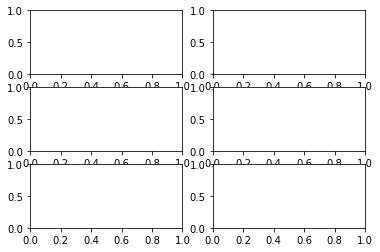

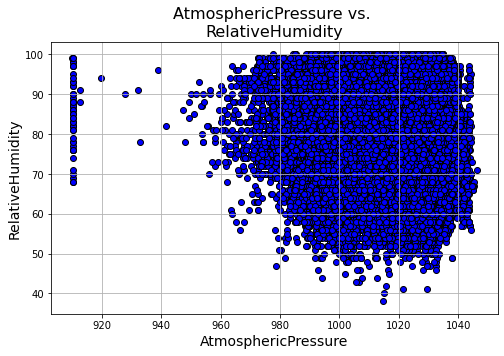

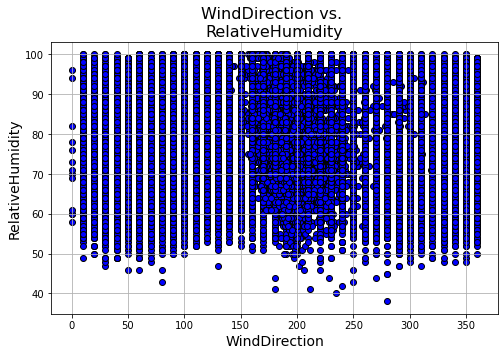

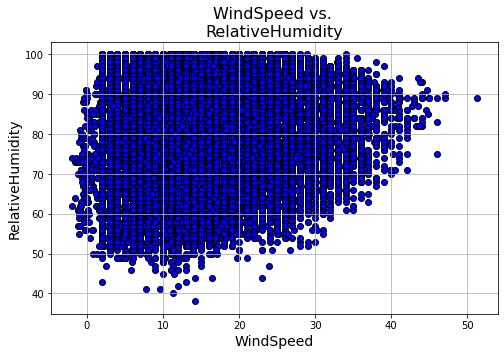

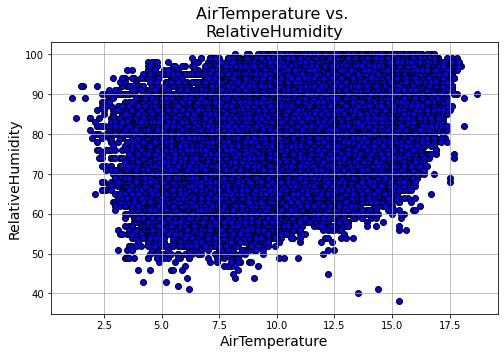

In [5]:

for c in df_train.columns[:-1]:
    plt.figure(figsize=(8,5))
    plt.title("{} vs. \nRelativeHumidity".format(c),fontsize=16)
    plt.scatter(x=df_train[c],y=df_train['RelativeHumidity'],color='blue',edgecolor='k')
    plt.grid(True)
    plt.xlabel(c,fontsize=14)
    plt.ylabel('RelativeHumidity',fontsize=14)
    plt.show()

#### Here a Custom Scaler is used that was developed with other iterations of the data set 
#### specifially for fitting the target variable and the Xtrain separately and for Data Extraction methods which were PCA,ICA

In [6]:
X_train_unscaled = df_train.iloc[:,: -1].values
y_train_unscaled = df_train.iloc[:, -1].values
X_test_unscaled = df_test.iloc[:, :-1].values
y_test_unscaled = df_test.iloc[:, -1].values
print(X_train_unscaled.shape)

class CustomScaler():
    
        def __init__(self, X_Scale, y_Scale ) :
        
            self.X_Scale =   X_Scale 
            self.y_Scale =   y_Scale
            
            self.x_num =     [np.mean(self.X_Scale[:,i]) for i in range(self.X_Scale.shape[1])]
            self.x_maxs =    [np.max(self.X_Scale[:,i]) for i in range(self.X_Scale.shape[1])]
            self.x_mins =    [np.min(self.X_Scale[:,i]) for i in range(self.X_Scale.shape[1])]
            
            self.y_num =     np.mean(self.y_Scale)
            self.y_max_min = np.max(self.y_Scale) - np.min(self.y_Scale)

        def scaleX(self, x_value):
            x = x_value.copy()
            for i in range(x.shape[1]):
                
                x[:,i]= (x[:,i] - self.x_num[i])/(self.x_maxs[i]-self.x_mins[i])
            return x

        def inverseScaleX(self, x_value):
            x = x_value.copy()
            
            for i in range(x.shape[1]):
                x[:,i]= (x[:,i] * (self.x_maxs[i]-self.x_mins[i])) + self.x_num[i]
            return x



        

        def scaleY(self, y_value):
            y = y_value.copy()
            ys = (y - self.y_num)/(self.y_max_min)
            return ys

        def inverseScaleY(self, y_value):
            y = y_value.copy()
            ys = (y * self.y_max_min) + self.y_num
            return ys


        



custom_scaler = CustomScaler(X_train_unscaled,y_train_unscaled)
    
X_train = custom_scaler.scaleX(X_train_unscaled.copy())
y_train = custom_scaler.scaleY(y_train_unscaled.copy())
transform = None


print(X_train[-70000: -1])

print(X_test_unscaled[:10,:],y_test_unscaled[:10])



(87983, 4)
[[ 0.05449026  0.12287241 -0.25085742 -0.06839196]
 [-0.03342183 -0.04379426  0.08658579  0.22138077]
 [-0.13159033 -0.09934982 -0.06338897  0.18160804]
 ...
 [ 0.12775033 -0.29379426 -0.15712319 -0.27293741]
 [-0.01437421  0.12287241  0.06783895  0.03388077]
 [-0.13305553 -0.15490537  0.13900713 -0.03998287]]
[[1019.6         250.           17.33182056    9.8       ]
 [1001.3         320.           25.            9.8       ]
 [1019.2         150.           19.12774672   13.1       ]
 [1024.           10.           16.            7.5       ]
 [1005.6         290.           19.            7.8       ]
 [1016.          180.           14.71158604   12.1       ]
 [1002.9         150.           33.           11.        ]
 [1017.3         250.           17.           15.4       ]
 [1005.9         240.           14.           15.        ]
 [1006.8         280.            6.            8.3       ]] [78. 78. 81. 76. 60. 94. 94. 91. 80. 80.]


## Here the Neural Network Model a Multi Layer Perceptron is Configured 
## Cross Val is the commented out section which was used for validation of the network. 

In [8]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')

opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.7,
    beta_2=0.88,
    epsilon=1e-07,
    amsgrad=False,)

def build_model(optimizer="sgd", activation = 'relu'):    
    model = keras.Sequential()
    model.add(Dense(500 ,activation = activation,input_dim = X_train.shape[1], name = "layer1"))
    model.add(Dense(1000, activation = activation, name = "layer2"))
    model.add(Dense(1000 ,activation = activation, name = "layer3"))
    model.add(Dense(500 ,activation = activation, name = "layer4"))

   
    model.add(Dense(1, name = "layer7"))
    model.compile(loss=["mean_squared_error"] ,optimizer=opt)
    return model

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

regression_model = KerasRegressor(build_fn=build_model, epochs=500, batch_size=1024, verbose=1,callbacks=[es])
history=regression_model.fit(X_train, y_train)




# from sklearn.model_selection import cross_val_score
# regressor = KerasRegressor(build_fn = build_model, batch_size = 1024, epochs = 100)
# accuracies = cross_val_score(estimator = regressor, X = X_train, y = y_train,scoring='neg_mean_squared_error',cv = 5, n_jobs = 1)
# mean = accuracies.mean()
# variance = accuracies.std()
# print(mean)
# print(variance)



Epoch 1/500
86/86 [==============================] - 1s 14ms/step - loss: 0.0207
Epoch 2/500
86/86 [==============================] - 1s 14ms/step - loss: 0.0197
Epoch 3/500
86/86 [==============================] - 1s 14ms/step - loss: 0.0194
Epoch 4/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0192
Epoch 5/500
86/86 [==============================] - 1s 13ms/step - loss: 0.0190
Epoch 6/500
86/86 [==============================] - 1s 14ms/step - loss: 0.0189
Epoch 7/500
86/86 [==============================] - 1s 13ms/step - loss: 0.0187
Epoch 8/500
86/86 [==============================] - 1s 12ms/step - loss: 0.0186
Epoch 9/500
86/86 [==============================] - 1s 11ms/step - loss: 0.0184
Epoch 10/500
86/86 [==============================] - 1s 14ms/step - loss: 0.0183
Epoch 11/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0182
Epoch 12/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0181
Epoch 13/500
86/86 [=====

Epoch 32/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0163
Epoch 33/500
86/86 [==============================] - 1s 14ms/step - loss: 0.0162
Epoch 34/500
86/86 [==============================] - 1s 14ms/step - loss: 0.0161
Epoch 35/500
86/86 [==============================] - 1s 14ms/step - loss: 0.0160
Epoch 36/500
86/86 [==============================] - 1s 12ms/step - loss: 0.0159
Epoch 37/500
86/86 [==============================] - 1s 14ms/step - loss: 0.0158
Epoch 38/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0158
Epoch 39/500
86/86 [==============================] - 1s 14ms/step - loss: 0.0157
Epoch 40/500
86/86 [==============================] - 1s 13ms/step - loss: 0.0156
Epoch 41/500
86/86 [==============================] - 1s 14ms/step - loss: 0.0155
Epoch 42/500
86/86 [==============================] - 1s 13ms/step - loss: 0.0155
Epoch 43/500
86/86 [==============================] - 1s 13ms/step - loss: 0.0154
Epoch 44/500
86/

86/86 [==============================] - 1s 13ms/step - loss: 0.0140
Epoch 63/500
86/86 [==============================] - 1s 12ms/step - loss: 0.0139
Epoch 64/500
86/86 [==============================] - 1s 12ms/step - loss: 0.0139
Epoch 65/500
86/86 [==============================] - 1s 14ms/step - loss: 0.0138
Epoch 66/500
86/86 [==============================] - 1s 14ms/step - loss: 0.0137
Epoch 67/500
86/86 [==============================] - 1s 14ms/step - loss: 0.0137
Epoch 68/500
86/86 [==============================] - 1s 14ms/step - loss: 0.0136
Epoch 69/500
86/86 [==============================] - 1s 14ms/step - loss: 0.0135
Epoch 70/500
86/86 [==============================] - 1s 14ms/step - loss: 0.0135
Epoch 71/500
86/86 [==============================] - 1s 13ms/step - loss: 0.0134
Epoch 72/500
86/86 [==============================] - 1s 12ms/step - loss: 0.0133
Epoch 73/500
86/86 [==============================] - 1s 14ms/step - loss: 0.0133
Epoch 74/500
86/86 [=========

86/86 [==============================] - 1s 13ms/step - loss: 0.0120
Epoch 94/500
86/86 [==============================] - 1s 12ms/step - loss: 0.0120
Epoch 95/500
86/86 [==============================] - 1s 14ms/step - loss: 0.0119
Epoch 96/500
86/86 [==============================] - 1s 14ms/step - loss: 0.0119
Epoch 97/500
86/86 [==============================] - 1s 13ms/step - loss: 0.0118
Epoch 98/500
86/86 [==============================] - 1s 14ms/step - loss: 0.0117
Epoch 99/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0117
Epoch 100/500
86/86 [==============================] - 1s 12ms/step - loss: 0.0116
Epoch 101/500
86/86 [==============================] - 1s 12ms/step - loss: 0.0116
Epoch 102/500
86/86 [==============================] - 1s 12ms/step - loss: 0.0115
Epoch 103/500
86/86 [==============================] - 1s 12ms/step - loss: 0.0115
Epoch 104/500
86/86 [==============================] - 1s 12ms/step - loss: 0.0114
Epoch 105/500
86/86 [===

86/86 [==============================] - 1s 12ms/step - loss: 0.0103
Epoch 125/500
86/86 [==============================] - 1s 14ms/step - loss: 0.0103
Epoch 126/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0103
Epoch 127/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0102
Epoch 128/500
86/86 [==============================] - 1s 13ms/step - loss: 0.0102
Epoch 129/500
86/86 [==============================] - 1s 13ms/step - loss: 0.0101
Epoch 130/500
86/86 [==============================] - 1s 12ms/step - loss: 0.0100
Epoch 131/500
86/86 [==============================] - 1s 13ms/step - loss: 0.0100
Epoch 132/500
86/86 [==============================] - 1s 14ms/step - loss: 0.0100
Epoch 133/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0099
Epoch 134/500
86/86 [==============================] - 1s 13ms/step - loss: 0.0099
Epoch 135/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0098
Epoch 136/500
86/8

86/86 [==============================] - 1s 15ms/step - loss: 0.0089
Epoch 156/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0089
Epoch 157/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0089
Epoch 158/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0089
Epoch 159/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0088
Epoch 160/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0088
Epoch 161/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0087
Epoch 162/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0087
Epoch 163/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0086
Epoch 164/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0086
Epoch 165/500
86/86 [==============================] - 1s 13ms/step - loss: 0.0086
Epoch 166/500
86/86 [==============================] - 1s 14ms/step - loss: 0.0086
Epoch 167/500
86/8

Epoch 186/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0079
Epoch 187/500
86/86 [==============================] - 1s 14ms/step - loss: 0.0078
Epoch 188/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0078
Epoch 189/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0077
Epoch 190/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0077
Epoch 191/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0077
Epoch 192/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0076
Epoch 193/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0076
Epoch 194/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0076
Epoch 195/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0075
Epoch 196/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0075
Epoch 197/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0075
Epoc

Epoch 217/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0069
Epoch 218/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0069
Epoch 219/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0069
Epoch 220/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0069
Epoch 221/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0068
Epoch 222/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0068
Epoch 223/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0068
Epoch 224/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0068
Epoch 225/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0067
Epoch 226/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0067
Epoch 227/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0067
Epoch 228/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0067
Epoc

86/86 [==============================] - 1s 16ms/step - loss: 0.0062
Epoch 248/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0062
Epoch 249/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0062
Epoch 250/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0062
Epoch 251/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0061
Epoch 252/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0061
Epoch 253/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0061
Epoch 254/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0061
Epoch 255/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0061
Epoch 256/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0060
Epoch 257/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0060
Epoch 258/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0060
Epoch 259/500
86/8

86/86 [==============================] - 1s 16ms/step - loss: 0.0056
Epoch 279/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0056
Epoch 280/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0056
Epoch 281/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0056
Epoch 282/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0055
Epoch 283/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0055
Epoch 284/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0055
Epoch 285/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0055
Epoch 286/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0055
Epoch 287/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0055
Epoch 288/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0054
Epoch 289/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0054
Epoch 290/500
86/8

86/86 [==============================] - 1s 17ms/step - loss: 0.0051
Epoch 310/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0051
Epoch 311/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0051
Epoch 312/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0051
Epoch 313/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0050
Epoch 314/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0051
Epoch 315/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0050
Epoch 316/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0050
Epoch 317/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0050
Epoch 318/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0050
Epoch 319/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0049
Epoch 320/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0050
Epoch 321/500
86/8

86/86 [==============================] - 1s 16ms/step - loss: 0.0047
Epoch 341/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0047
Epoch 342/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0046
Epoch 343/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0047
Epoch 344/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0046
Epoch 345/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0046
Epoch 346/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0046
Epoch 347/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0046
Epoch 348/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0046
Epoch 349/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0046
Epoch 350/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0046
Epoch 351/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0046
Epoch 352/500
86/8

86/86 [==============================] - 1s 16ms/step - loss: 0.0043
Epoch 372/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0043
Epoch 373/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0043
Epoch 374/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0043
Epoch 375/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0043
Epoch 376/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0043
Epoch 377/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0042
Epoch 378/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0043
Epoch 379/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0042
Epoch 380/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0042
Epoch 381/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0042
Epoch 382/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0042
Epoch 383/500
86/8

86/86 [==============================] - 1s 17ms/step - loss: 0.0040
Epoch 403/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0040
Epoch 404/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0040
Epoch 405/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0040
Epoch 406/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0040
Epoch 407/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0040
Epoch 408/500
86/86 [==============================] - 2s 18ms/step - loss: 0.0040
Epoch 409/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0039
Epoch 410/500
86/86 [==============================] - 1s 14ms/step - loss: 0.0039
Epoch 411/500
86/86 [==============================] - 1s 14ms/step - loss: 0.0039
Epoch 412/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0039
Epoch 413/500
86/86 [==============================] - 2s 18ms/step - loss: 0.0039
Epoch 414/500
86/8

86/86 [==============================] - 2s 18ms/step - loss: 0.0037
Epoch 434/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0037
Epoch 435/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0037
Epoch 436/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0037
Epoch 437/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0037
Epoch 438/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0037
Epoch 439/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0037
Epoch 440/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0037
Epoch 441/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0037
Epoch 442/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0037
Epoch 443/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0036
Epoch 444/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0037
Epoch 445/500
86/8

86/86 [==============================] - 1s 17ms/step - loss: 0.0035
Epoch 465/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0035
Epoch 466/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0035
Epoch 467/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0035
Epoch 468/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0035
Epoch 469/500
86/86 [==============================] - 1s 14ms/step - loss: 0.0034
Epoch 470/500
86/86 [==============================] - 1s 14ms/step - loss: 0.0034
Epoch 471/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0034
Epoch 472/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0034
Epoch 473/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0034
Epoch 474/500
86/86 [==============================] - 1s 16ms/step - loss: 0.0035
Epoch 475/500
86/86 [==============================] - 2s 18ms/step - loss: 0.0034
Epoch 476/500
86/8

86/86 [==============================] - 2s 18ms/step - loss: 0.0033
Epoch 496/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0033
Epoch 497/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0033
Epoch 498/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0033
Epoch 499/500
86/86 [==============================] - 1s 17ms/step - loss: 0.0033
Epoch 500/500
86/86 [==============================] - 2s 18ms/step - loss: 0.0032


### Here we test the model on De Normalized Predictions using the custom scaler with the test set 

In [9]:
from sklearn.metrics import mean_squared_error
transformer = None
if transformer:
    y_pred = regression_model.predict(transformer.transform(custom_scaler.scaleX(np.asarray(X_test_unscaled).astype('float32'))))
else :
    y_pred = regression_model.predict((custom_scaler.scaleX(np.asarray(X_test_unscaled).astype('float32'))))

# y_pred = max_min*y_pred + y_min
y_pred_unscaled = custom_scaler.inverseScaleY(y_pred)
print(mean_squared_error(custom_scaler.inverseScaleY(y_pred), y_test_unscaled))

22/22 [==============================] - 0s 8ms/step
81.20521748463402


### Here other Metrics used in the model are used

In [10]:
from sklearn.metrics import r2_score, mean_absolute_error, max_error
r2 = r2_score(y_pred_unscaled, y_test_unscaled)
mae = mean_absolute_error(y_pred_unscaled, y_test_unscaled)
me =  max_error(y_pred_unscaled, y_test_unscaled)
adj_r2 = 1 - (1-r2)*(len(y_test_unscaled)-1)/(len(y_test_unscaled)-X_test_unscaled.shape[1]-1)
print("R squred is ",r2)
print("Mean Absolute Error is ",mae)
print("Max Error is ",me)
print("Adjusted R squred is ",adj_r2)

R squred is  0.11998724241002534
Mean Absolute Error is  6.680279122328494
Max Error is  51.91581726074219
Adjusted R squred is  0.11982717460818093


## 2 Plots 1. Model Loss while Training 2. Residual Plot are shown below

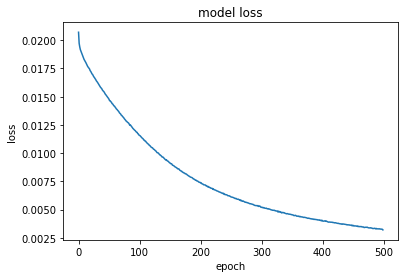

In [11]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

## The Predicted De Normalized and Un Sclaed Predictions and True Test target Values are shown together for Comparison

In [12]:
np.column_stack((y_test_unscaled,custom_scaler.inverseScaleY(y_pred)))

array([[78.        , 78.70800781],
       [78.        , 78.31279755],
       [81.        , 94.01133728],
       ...,
       [68.        , 70.8266449 ],
       [89.        , 81.17285919],
       [73.        , 77.35382843]])

# Here We Try and Test Our Model on Live Unseen Data Collected for the 21st OF December 2020

In [13]:
df_unseen = pd.read_csv("UnseenTest.csv")

In [14]:
df_unseen.head()

,ID,name,wmoID,time,pressure,windDir,windSpeed,windGust,temp,dewPoint,humidity,period,height,seaTemp,reportDate,reportTime,updated_At,created_at
0,444313,M5,62094,19 Dec 11:00,995.3,212,46,61,10.8,6.7,76,7.3,4.5,11.0,19-12-2020,11:00,2020-12-19 12:15:28,2020-12-19 12:15:28
1,444325,M5,62094,19 Dec 12:00,995.4,220,48,61,11.2,6.7,74,7.3,4.3,11.0,19-12-2020,12:00,2020-12-19 12:21:06,2020-12-19 12:21:06
2,444343,M5,62094,19 Dec 13:00,996.2,235,48,65,10.6,4.9,68,7.4,4.5,11.1,19-12-2020,13:00,2020-12-19 13:21:06,2020-12-19 13:21:06
3,444361,M5,62094,19 Dec 14:00,997.2,249,37,-,9.5,5.5,76,7.3,4.5,11.0,19-12-2020,14:00,2020-12-19 14:21:22,2020-12-19 14:21:22
4,444385,M5,62094,19 Dec 15:00,997.5,242,24,-,9.3,6.6,83,7.9,4.6,11.0,19-12-2020,15:00,2020-12-19 15:20:32,2020-12-19 15:20:32


In [18]:
x_unseen =df_unseen[["pressure","windDir","windSpeed","temp"]].values
y_unseen = df_unseen["humidity"].values

In [19]:
unseen_out = regression_model.predict((custom_scaler.scaleX(np.asarray(x_unseen).astype('float32'))))
unseen_out_unscaled = custom_scaler.inverseScaleY(unseen_out)
unseen_out_unscaled

1/1 [==============================] - 0s 961us/step


array([88.22285 , 85.97001 , 88.6567  , 87.93996 , 72.47054 , 96.7382  ,
       87.69794 , 87.450165, 88.3997  , 88.82667 , 89.51314 , 89.902794,
       80.635475, 77.599724, 76.26422 , 64.958565, 77.21893 , 83.51023 ,
       74.62408 , 83.88928 , 83.416374, 82.13895 , 82.80997 , 83.729324,
       70.49311 , 64.31237 ], dtype=float32)

## Metrics for the new unseen data

In [20]:
print(mean_squared_error(unseen_out_unscaled, y_unseen))

131.21947821382827


In [21]:
from sklearn.metrics import r2_score
r2 = r2_score(unseen_out_unscaled, y_unseen)
adj_r2 = 1 - (1-r2)*(len(y_unseen)-1)/(len(y_unseen)-x_unseen.shape[1]-1)

In [22]:
r2

-1.1481605724823734

In [23]:
adj_r2

-1.5573340148599684

In [24]:
from sklearn.metrics import max_error
max_error(unseen_out_unscaled, y_unseen)

21.738197326660156

In [25]:
residuals = y_unseen - unseen_out_unscaled

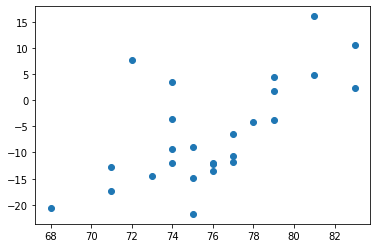

In [26]:
residuals.shape
plt.scatter(y_unseen, residuals)

plt.show()

## Comparing the Predictions vs the Unseen Data Values

In [27]:
np.column_stack((y_unseen, unseen_out_unscaled))

array([[76.        , 88.22284698],
       [74.        , 85.97000885],
       [68.        , 88.65670013],
       [76.        , 87.93995667],
       [83.        , 72.47054291],
       [75.        , 96.73819733],
       [77.        , 87.69793701],
       [73.        , 87.45016479],
       [71.        , 88.39969635],
       [77.        , 88.82666779],
       [76.        , 89.51313782],
       [75.        , 89.90279388],
       [83.        , 80.63547516],
       [74.        , 77.59972382],
       [81.        , 76.26422119],
       [81.        , 64.95856476],
       [79.        , 77.21893311],
       [77.        , 83.51023102],
       [79.        , 74.62407684],
       [75.        , 83.88928223],
       [74.        , 83.41637421],
       [78.        , 82.13894653],
       [79.        , 82.80996704],
       [71.        , 83.72932434],
       [74.        , 70.49311066],
       [72.        , 64.3123703 ]])